Este codigo es para reestructurar el código y tener 3 niveles para ajustarlo al papper


In [ ]:
#Download libraries before importing.
!pip install regionmask
!pip install salem
!pip install rasterio
!pip install rioxarray
!pip install gdown
!pip install pykrige==1.7.2
!pip install scikit-learn==1.0.2 #version to ensure compatibility

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.7/909.7 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 25.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requi

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
import regionmask
import geopandas as gpd
import salem
import rasterio as rio
from osgeo import gdal
import rioxarray as rio
from google.colab import files
import gdown
import geopandas as gpd
from shapely.geometry import Point
from scipy.interpolate import griddata
from matplotlib.ticker import FuncFormatter
from pykrige.ok import OrdinaryKriging
import matplotlib.dates as mdates

#### **Level 1. Get landslide occurrence probability in Andean Zone with Chirps Data**

In [ ]:
#Download and read model for Chirps data
gdown.download("https://drive.google.com/uc?export=download&id=10Vt9HRgHMB8VR_kYMi2b91ZhN5RWaFlx", "finalized_model_RF_andina_chirps.sav", quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=10Vt9HRgHMB8VR_kYMi2b91ZhN5RWaFlx
To: /content/finalized_model_RF_andina_chirps.sav
100%|██████████| 19.2M/19.2M [00:00<00:00, 51.4MB/s]


'finalized_model_RF_andina_chirps.sav'

In [ ]:
# Assign model file and read
chirps_model_file = 'finalized_model_RF_andina_chirps.sav'
# Read model file from CHIRPS
chirps_model= pickle.load(open(chirps_model_file, 'rb'))

#Important note: If is not working restart session with "Runtime" option

In [ ]:
#Input rainfall data for chirps

#The file (csv,xlsx,txt) must contain the following columns and format within the parenthesis:
  #ID_pixel (int64) , data (datetime64 exm: 7/13/2022  12:00:00 AM ), daily rain (float64), 1-rain ant.rain (float64),...
  # ... 2-rain ant.rain (float64), 3-rain ant.rain (float64), 15-rain ant.rain (float64), 30-rain ant.rain (float64)

#Upload rainfall file for Chirps
archivo_lluvia = files.upload()

def cargar_archivo(nombre_archivo):
    if nombre_archivo.endswith('.xlsx'):
        return pd.read_excel(nombre_archivo)
    elif nombre_archivo.endswith('.csv'):
        return pd.read_csv(nombre_archivo)
    elif nombre_archivo.endswith('.txt'):
        return pd.read_csv(nombre_archivo, delimiter='\t')  # ES.  Asume tabulación para archivos .txt
    else:
        raise ValueError("Unsupported file. ES- Formato de archivo no soportado")


KeyboardInterrupt: 

In [ ]:

#Extract file content
nombre_archivo = list(archivo_lluvia.keys())[0]

#Load the file in dataframe
df_chirps = cargar_archivo(nombre_archivo)

#Delete missing data
df_chirps = df_chirps.dropna()


Saving chirps_test_medellin_sanantoprado2022713.xlsx to chirps_test_medellin_sanantoprado2022713 (1).xlsx


In [ ]:
#Select variables

variables = ['daily rain', '1-rain ant.rain',
        '3-rain ant.rain', '15-rain ant.rain',
       '30-rain ant.rain']

#filter dataframe with selected variables
df_chirps2=df_chirps[variables]

In [ ]:
#Standarize data to use landslide prediction model

X= sc.fit_transform(df_chirps2)
X_test2= sc.transform(df_chirps2)

In [ ]:
#Get landslide probability ocurrences

y_pred2p = chirps_model.predict(X_test2)
y_pred_prob2p=chirps_model.predict_proba(X_test2)
y_pred_prob33p =y_pred_prob2p[:, 1]

#add Probability column to dataframe
df_chirps['prob_ep']=y_pred_prob33p

In [ ]:
#Upload the region of interest in shapefile format (Grid chirps)

shapefile_archivo = files.upload()

Saving cuadricula_chirps_andina.sbn to cuadricula_chirps_andina.sbn
Saving cuadricula_chirps_andina.sbx to cuadricula_chirps_andina.sbx
Saving cuadricula_chirps_andina.shp to cuadricula_chirps_andina.shp
Saving cuadricula_chirps_andina.shx to cuadricula_chirps_andina.shx
Saving cuadricula_chirps_andina.cpg to cuadricula_chirps_andina.cpg
Saving cuadricula_chirps_andina.dbf to cuadricula_chirps_andina.dbf
Saving cuadricula_chirps_andina.shp.xml to cuadricula_chirps_andina.shp.xml
Saving cuadricula_chirps_andina.prj to cuadricula_chirps_andina.prj


In [ ]:
#Read the file and insert the name in the argument
region_coordenadas = gpd.read_file('cuadricula_chirps_andina.shp')

In [ ]:
#Define the region limit with shapefile format
uploaded=files.upload()


Saving medellin2.shp.DESKTOP-KAI0TQH.1516.2988.sr.lock to medellin2.shp.DESKTOP-KAI0TQH.1516.2988.sr.lock
Saving medellin2.cpg to medellin2.cpg
Saving medellin2.dbf to medellin2.dbf
Saving medellin2.prj to medellin2.prj
Saving medellin2.sbn to medellin2.sbn
Saving medellin2.sbx to medellin2.sbx
Saving medellin2.shp to medellin2.shp
Saving medellin2.shp.xml to medellin2.shp.xml
Saving medellin2.shx to medellin2.shx


In [ ]:
#Read the file limit region, insert shapefile in the argument
limite_region=gpd.read_file('medellin2.shp')


In [ ]:
#Merge landslide probability and area of interest
df_prob_chirps= pd.merge(region_coordenadas,df_chirps,how="left",left_on=['OBJECTID'],right_on=['ID_pixel'])

#Drop missing data from probability lanslide column
df_prob_chirps=df_prob_chirps.dropna(subset=['prob_ep'])


#Filter data to include just chirps cells that interects with limit region
df_prob_chirps_filtrado = df_prob_chirps[df_prob_chirps.intersects(limite_region.union_all())]


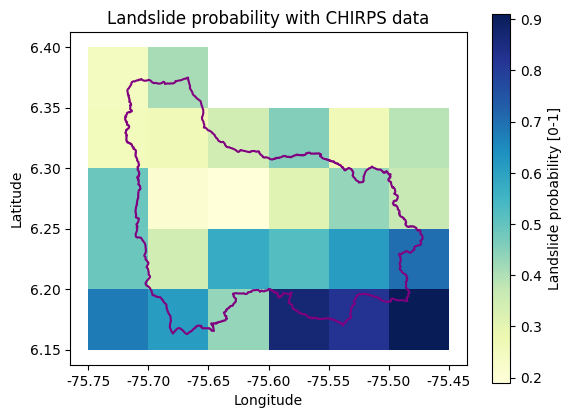

In [ ]:
#Generate the plot


#Create the plot
fig, ax = plt.subplots(1, 1)

#Select probability >0
world=df_prob_chirps[(df_prob_chirps.prob_ep>=0)]

#To assure that just the area of interest is plot:
#world=df_prob_chirps_filtrado[(df_prob_chirps_filtrado.prob_ep>=0)]

#Plot the region limit for the main map
limite_region.boundary.plot(ax=ax,color='purple', edgecolor='red')

#Plot landslide probabilities (0 to 1)
world.plot(column='prob_ep', cmap="YlGnBu",
             ax=ax,
             legend=True,
             legend_kwds={'label': "Landslide probability [0-1]",
                            'orientation': "vertical"})


#Customize axis labels
ax.set_xlabel("Longitude", fontsize=10)
ax.set_ylabel("Latitude", fontsize=10)

#Show 2 decimals for the plot
def format_two_decimals(x, _):
    return f"{x:.2f}"

# Show 2 decimals for longitude and latitude
ax.xaxis.set_major_formatter(FuncFormatter(format_two_decimals))
ax.yaxis.set_major_formatter(FuncFormatter(format_two_decimals))

#Show title
plt.title('Landslide probability with CHIRPS data', fontsize=12)

plt.show()


### **Level 2**

#### In case the user has daily rainfall data from gauges in the area of interest

In [ ]:
#Read and download Model for daily data from rainfall gauges

gdown.download("https://drive.google.com/uc?export=download&id=1gSDPM7g25Gn_Ql6vUCl0XMhmyUzCdMJ5", "finalized_model_RF_andina_ideam.sav", quiet=False)


Downloading...
From: https://drive.google.com/uc?export=download&id=1gSDPM7g25Gn_Ql6vUCl0XMhmyUzCdMJ5
To: /content/finalized_model_RF_andina_ideam.sav
100%|██████████| 27.1M/27.1M [00:01<00:00, 24.2MB/s]


'finalized_model_RF_andina_ideam.sav'

In [ ]:
#Read model file and open file
ideam_model_file = 'finalized_model_RF_andina_ideam.sav'
ideam_model= pickle.load(open(ideam_model_file, 'rb'))

In [ ]:
#Insert rainfall data

#The file (csv,xlsx,txt) must contain the following columns and format within the parenthesis:
  # codigo (int64) , data (datetime64 exm: 7/13/2022  12:00:00 AM ), daily rain (float64), 1-rain ant.rain (float64),...
  # ... 2-rain ant.rain (float64), 3-rain ant.rain (float64), 15-rain ant.rain (float64), 30-rain ant.rain (float64)

archivo_lluvia_l2 = files.upload()

#Extract file content
nombre_archivo_l2 = list(archivo_lluvia_l2.keys())[0]

#Load file in dataframe
df_lluvia_l2 = cargar_archivo(nombre_archivo_l2)

#Delete Nan data
df_lluvia_l2 = df_lluvia_l2.dropna()


Saving ideam_test_medellin_sanantprado2022713.xlsx to ideam_test_medellin_sanantprado2022713.xlsx


In [ ]:
#Select variables

variables_l2 = ['daily rain', '1-rain ant.rain',
        '3-rain ant.rain', '15-rain ant.rain',
       '30-rain ant.rain']

#Filter dataframe with variables
df_lluvia2_l2=df_lluvia_l2[variables_l2]

In [ ]:
#Standarize dataframe to use model

X_l2= sc.fit_transform(df_lluvia2_l2)
X_test2_l2= sc.transform(df_lluvia2_l2)



In [ ]:
#Use model with rain gauges data

y_pred2p_2= ideam_model.predict(X_test2_l2)
y_pred_prob2p_2=ideam_model.predict_proba(X_test2_l2)
y_pred_prob33p_2 =y_pred_prob2p_2[:, 1]

#Add probability column to dataframe
df_lluvia_l2['prob_ep']=y_pred_prob33p_2

In [ ]:
#Insert shapefile of rainfall gauges for the andean zone

shapefile_archivo_l2 = files.upload()

Saving CNE_IDEAM_andeanregion_figprob.dbf to CNE_IDEAM_andeanregion_figprob.dbf
Saving CNE_IDEAM_andeanregion_figprob.qix to CNE_IDEAM_andeanregion_figprob.qix
Saving CNE_IDEAM_andeanregion_figprob.shp to CNE_IDEAM_andeanregion_figprob.shp
Saving CNE_IDEAM_andeanregion_figprob.shx to CNE_IDEAM_andeanregion_figprob.shx
Saving CNE_IDEAM_andeanregion_figprob.cpg to CNE_IDEAM_andeanregion_figprob.cpg
Saving CNE_IDEAM_andeanregion_figprob.prj to CNE_IDEAM_andeanregion_figprob.prj
Saving CNE_IDEAM_andeanregion.shp.DESKTOP-KAI0TQH.2152.5856.sr.lock to CNE_IDEAM_andeanregion.shp.DESKTOP-KAI0TQH.2152.5856.sr.lock


In [ ]:
#Read the shapefil (insert shp file name inside the argumen)

region_coordenadas_l2 = gpd.read_file('CNE_IDEAM_andeanregion_figprob.shp')


In [ ]:
#Insert shapefile of area of interest
uploaded=files.upload()

Saving medellin2.shp.DESKTOP-KAI0TQH.1516.2988.sr.lock to medellin2.shp.DESKTOP-KAI0TQH.1516.2988.sr (1).lock
Saving medellin2.cpg to medellin2 (1).cpg
Saving medellin2.dbf to medellin2 (1).dbf
Saving medellin2.prj to medellin2 (1).prj
Saving medellin2.sbn to medellin2 (1).sbn
Saving medellin2.sbx to medellin2 (1).sbx
Saving medellin2.shp to medellin2 (1).shp
Saving medellin2.shp.xml to medellin2.shp (1).xml
Saving medellin2.shx to medellin2 (1).shx


In [ ]:
#Read the region limit, area of interest
 #Insert the shp name inside the argument

limite_region_l2=gpd.read_file('medellin2.shp')

In [ ]:
#Merge probability occurrences with shapefile region
df_prob_lluvia_l2= pd.merge(region_coordenadas_l2,df_lluvia_l2,how="left",left_on=['codigo_1'],right_on=['codigo'])

#Drop missing data (Nan)
df_prob_lluvia_l2=df_prob_lluvia_l2.dropna(subset=['prob_ep'])

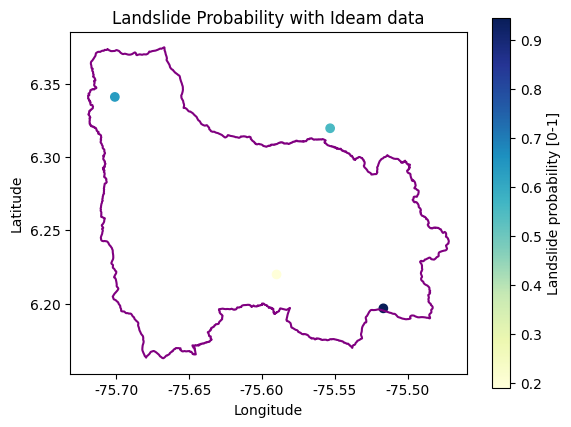

In [ ]:
#Plot the data

#This is a point plot without interpolation

#Create figure
# ES. Se crea la figura
fig, ax = plt.subplots(1, 1)

#Selecct Lanslide probability > 0
world_l2=df_prob_lluvia_l2[(df_prob_lluvia_l2.prob_ep>=0)]

#Plot the region limit
limite_region_l2.boundary.plot(ax=ax,color='purple', edgecolor='red')

#Plot landslite probability
ax.set_title("Landslide Probability with Ideam data", fontsize=12)
world_l2.plot(column='prob_ep', cmap="YlGnBu",
             ax=ax,
             legend=True,
             legend_kwds={'label': "Landslide probability [0-1]",
                            'orientation': "vertical"})

ax.xaxis.set_major_formatter(FuncFormatter(format_two_decimals))
ax.yaxis.set_major_formatter(FuncFormatter(format_two_decimals))

#Customize axis labels
ax.set_xlabel("Longitude", fontsize=10)
ax.set_ylabel("Latitude", fontsize=10)

#erase the axis for a clearer map
#ax.set_axis_off()

#Show plot

plt.show()

###### **To get landslide occurrences probabilities for the whole map 2 interpolation methods are available: IDW and Splines**

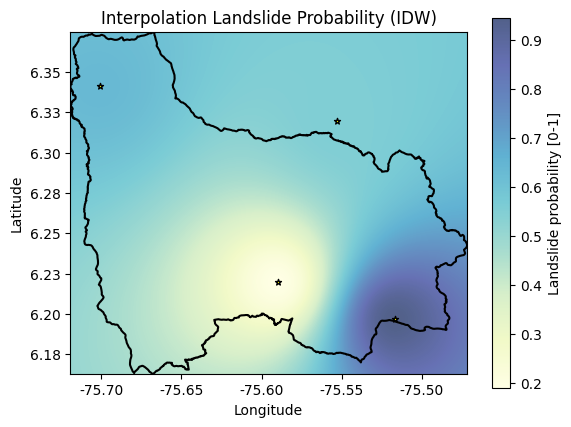

In [ ]:
#IDW interpolation method
#Select variables and create geodataframe
variables = ['CODIGO', 'nombre', 'CATEGORIA', 'TECNOLOGIA', 'ESTADO',
             'altitud', 'latitud', 'longitud', 'DEPARTAMEN', 'MUNICIPIO',
             'geometry', 'prob_ep']
gdf_l2 = gpd.GeoDataFrame(df_prob_lluvia_l2[variables], geometry='geometry')

#Convert geometry to points
points= np.array([[geom.x, geom.y] for geom in gdf_l2.geometry])
values= gdf_l2['prob_ep'].values

#Get region limits
min_x, min_y, max_x, max_y = limite_region_l2.total_bounds

#Create interpolation grid
grid_x, grid_y = np.mgrid[min_x:max_x:500j, min_y:max_y:500j]

#Interpolation IDW function
def idw_interpolation(x, y, values, xi, yi, power=2):
    # Inicialize results matrix. ES: Inicializar matriz de resultados
    interpolated_values = np.zeros(xi.shape)

    # iterate on every point of the grid
    for i in range(xi.shape[0]):
        for j in range(xi.shape[1]):
            #Calculate distance of point in grid
            dist = np.sqrt((x - xi[i, j])**2 + (y - yi[i, j])**2)

            #Avoid division by zero

            if np.any(dist == 0):
                interpolated_values[i, j] = values[dist.argmin()]
            else:
              #Calculate distance inverse weights

                weights = 1 / dist**power
                interpolated_values[i, j] = np.sum(weights * values) / np.sum(weights)

    return interpolated_values

#generate  IDW interpolation
grid_z = idw_interpolation(points[:, 0], points[:, 1], values, grid_x, grid_y, power=2) # ES. el power 2 es estandar pero también puede ser 1 si se le quiere dar menor influencia a la distancia

# Result visualization
fig, ax = plt.subplots()
ax.set_title("Interpolation Landslide Probability (IDW)", fontsize=12 )
limite_region_l2.boundary.plot(ax=ax, color='black', edgecolor='black')

# Show 2 decimals
ax.xaxis.set_major_formatter(FuncFormatter(format_two_decimals))
ax.yaxis.set_major_formatter(FuncFormatter(format_two_decimals))

#Customize axis labels
ax.set_xlabel("Longitude", fontsize=10)
ax.set_ylabel("Latitude", fontsize=10)

#Show interpolation in the whole square
cax = ax.imshow(grid_z.T, extent=(min_x, max_x, min_y, max_y),
                origin='lower', cmap='YlGnBu', alpha=0.7)
plt.colorbar(cax, label='Landslide probability [0-1]')

#Points of original gauges
gdf_l2.plot(ax=ax, markersize=20, color='yellow', edgecolor='black', marker='*')
plt.show()


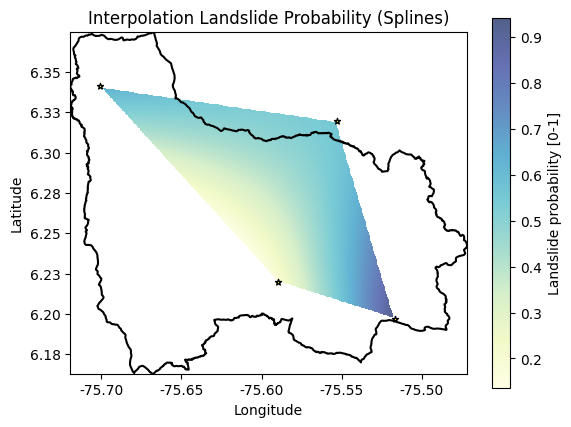

In [ ]:
#Splines interpolation method

#Variables
variables = ['CODIGO', 'nombre', 'CATEGORIA', 'TECNOLOGIA', 'ESTADO',
             'altitud', 'latitud', 'longitud', 'DEPARTAMEN', 'MUNICIPIO',
             'geometry', 'prob_ep']
gdf_l2 = gpd.GeoDataFrame(df_prob_lluvia_l2[variables], geometry='geometry')

points = np.array([[geom.x, geom.y] for geom in gdf_l2.geometry])
values = gdf_l2['prob_ep'].values

#Get region limits
min_x, min_y, max_x, max_y = limite_region_l2.total_bounds

#Create grid interpolation
grid_x, grid_y = np.mgrid[min_x:max_x:500j, min_y:max_y:500j]

#Cubic spline interpolation
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

#Visualize results
fig, ax = plt.subplots()
ax.set_title("Interpolation Landslide Probability (Splines)", fontsize=12)
limite_region_l2.boundary.plot(ax=ax, color='black', edgecolor='black')

#Customize axis labels
ax.set_xlabel("Longitude", fontsize=10)
ax.set_ylabel("Latitude", fontsize=10)

# Show 2 decimals
ax.xaxis.set_major_formatter(FuncFormatter(format_two_decimals))
ax.yaxis.set_major_formatter(FuncFormatter(format_two_decimals))

#Show the interpolation for the whole area
cax = ax.imshow(grid_z.T, extent=(min_x, max_x, min_y, max_y),
                origin='lower', cmap='YlGnBu', alpha=0.7)
plt.colorbar(cax, label='Landslide probability [0-1]')

#Original gauges
gdf_l2.plot(ax=ax, markersize=20, color='yellow', edgecolor='black', marker='*')
plt.show()





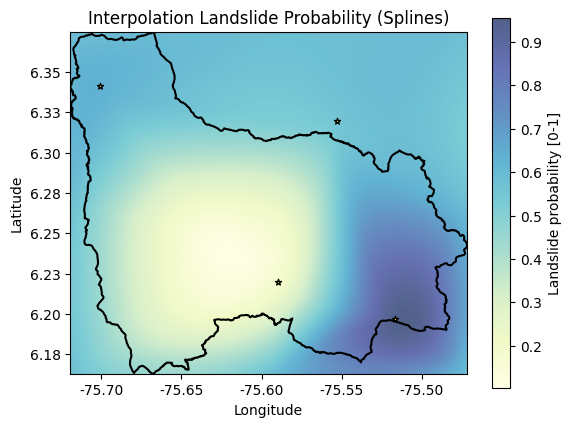

In [ ]:
#Spline method expanded

#Create artificial borders to visualize interpolation for the whole area of interest

min_x, min_y, max_x, max_y = limite_region_l2.total_bounds

#Convert geometry to points and get coordinates
points = np.array([[geom.x, geom.y] for geom in gdf_l2.geometry])
values = gdf_l2['prob_ep'].values  # ES.  Valores de probabilidad de deslizamiento

#Create artificial borders
border_points = np.array([
    [min_x, min_y], [min_x, max_y], [max_x, min_y], [max_x, max_y],
    [(min_x + max_x) / 2, min_y], [(min_x + max_x) / 2, max_y],
    [min_x, (min_y + max_y) / 2], [max_x, (min_y + max_y) / 2]
])

# Asigned estimated values for borders points
border_values = np.full(border_points.shape[0], values.mean())

#Concatenate original points with border points
all_points = np.concatenate([points, border_points])
all_values = np.concatenate([values, border_values])

#Create interpolation grid with region limits
grid_x, grid_y = np.mgrid[min_x:max_x:500j, min_y:max_y:500j]

#Apply cubic spline interpolation
grid_z = griddata(all_points, all_values, (grid_x, grid_y), method='cubic')

#Visualize results
fig, ax = plt.subplots()
ax.set_title("Interpolation Landslide Probability (Splines)", fontsize=12)
limite_region.boundary.plot(ax=ax, color='black', edgecolor='black')

# Show 2 decimals
ax.xaxis.set_major_formatter(FuncFormatter(format_two_decimals))
ax.yaxis.set_major_formatter(FuncFormatter(format_two_decimals))

#Customize axis labels
ax.set_xlabel("Longitude", fontsize=10)
ax.set_ylabel("Latitude", fontsize=10)

#Show interpolation in the whole square
cax = ax.imshow(grid_z.T, extent=(min_x, max_x, min_y, max_y),
                origin='lower', cmap='YlGnBu', alpha=0.7)
plt.colorbar(cax, label='Landslide probability [0-1]')

#Original gauges points
gdf_l2.plot(ax=ax, markersize=20, color='yellow', edgecolor='black', marker='*')
plt.show()





### **Level 3**

#### If user has hourly information from rain gauges near the area of interest.

In this level is possible to visualize Empirical Rainfall Thresholds

In [ ]:
#Upload rainfall information, 3rd level:
#The data must have the following columns:
    #...fecha_hora(provided in hours or minutes exm:11/1/2024  00:02 ),P1(precipitation values in mm), Codigo (ID of raingauge)

#Upload precipitation file for level 3
archivo_lluvia_l3 = files.upload()

#Extract file content
nombre_archivo_l3 = list(archivo_lluvia_l3.keys())[0]

#Create dataframe with CSV format
df_lluvia_l3= pd.read_csv(nombre_archivo_l3, encoding='latin-1')


IndexError: list index out of range

In [ ]:
#Organize de data for the model

#Be sure the time column is in datetime format.
df_lluvia_l3['fecha_hora'] = pd.to_datetime(df_lluvia_l3['fecha_hora'])

In [ ]:
#Function to organize data hourly

def set_hourly(df, interval='minute'):
  df['hora'] = df['fecha_hora'].dt.floor('h')  # Group by hours
  hourly_data = df.groupby(['hora', 'Codigo']).agg({'P1': 'sum'}).reset_index()
  hourly_data.rename(columns={'hora': 'fecha_hora', 'P1': 'rain_hourly'}, inplace=True)
  return hourly_data

#Get hourly data for preciptation
hourly_data=set_hourly(df_lluvia_l3)

In [ ]:
#Function to organize data daily after hourly data

def set_daily(df):
  df['fecha'] = df['fecha_hora'].dt.date  # Group by day
  daily_data = df.groupby(['fecha', 'Codigo']).agg({'rain_hourly': 'sum'}).reset_index()
  daily_data.rename(columns={'rain_hourly': 'daily_rain'}, inplace=True)
  return daily_data

#Get daily data for preciptation
daily_data=set_daily(hourly_data)

In [ ]:
#Fuction to get cumulative rain (antecedent rain) from daily precipitation data
 #Specific format for model input

def cumulative_rain(df, days_rain):

    # Ordenar por estación y fecha
    df.sort_values(by=['Codigo', 'fecha'], inplace=True)

    # Lista para almacenar resultados por estación
    resultados = []

    # Iterar por cada estación
    for codigo in df['Codigo'].unique():
        # Filtrar datos de la estación
        df_codigo = df[df['Codigo'] == codigo].copy()

        # Iterar sobre los días de acumulación
        for days in days_rain:
            # Calcular la suma acumulativa desplazada para cada rango de días
            df_codigo[f'{days}-rain ant.rain'] = (
                df_codigo['daily_rain']
                .rolling(window=days, min_periods=1)  # Acumular últimos 'days' días
                .sum()
                .shift(1)  # Desplazar 1 día hacia abajo
            ) + df_codigo['daily_rain']  # Sumar la lluvia del día actual

        resultados.append(df_codigo)

    # Combinar los resultados de todas las estaciones
    final_df = pd.concat(resultados, ignore_index=True)

    # scenarioar solo la última fecha registrada para cada estación
    final_df = final_df.loc[final_df.groupby('Codigo')['fecha'].idxmax()]

    return final_df



In [ ]:
#Use function of cumulative rain to organize rain data to input in model

#Antecedent rain days needed
days_rain = [1,2,3, 15, 30]
df_lluvia_l3 = cumulative_rain(daily_data, days_rain)

#Rename columns to model format
df_lluvia_l3.rename(columns={
    'Codigo': 'codigo',
    'fecha': 'data',
    'daily_rain': 'daily rain'
}, inplace=True)
df_lluvia_l3

,data,codigo,daily rain,1-rain ant.rain,2-rain ant.rain,3-rain ant.rain,15-rain ant.rain,30-rain ant.rain
29,2024-11-30,11111111,12.374000,14.406000,17.962000,23.296000,123.962215,201.435909
59,2024-11-30,27010770,109.594608,112.186608,115.742608,121.076608,262.073602,388.335602
89,2024-11-30,27015330,50.876851,52.908851,56.464851,61.798851,194.818518,369.371957


In [ ]:
##Select variables

variables_l3 = ['daily rain', '1-rain ant.rain',
        '3-rain ant.rain', '15-rain ant.rain',
       '30-rain ant.rain']

#Filter dataframe with variables
df_lluvia2_l3=df_lluvia_l3[variables_l3]


In [ ]:
#Standarize dataframe to use model

X_l3= sc.fit_transform(df_lluvia2_l3)
X_test2_l3= sc.transform(df_lluvia2_l3)


In [ ]:
#Use model with rain gauges data

y_pred2p_3= ideam_model.predict(X_test2_l3)
y_pred_prob2p_3=ideam_model.predict_proba(X_test2_l3)
y_pred_prob33p_3 =y_pred_prob2p_3[:, 1]

#Add probability column to dataframe
df_lluvia_l3['prob_ep']=y_pred_prob33p_3

In [ ]:
#Insert shapefile of rainfall gauges for the area of interest in andean zone

shapefile_archivo_l3 = files.upload()

Saving CNE_mod.cpg to CNE_mod (2).cpg
Saving CNE_mod.dbf to CNE_mod (2).dbf
Saving CNE_mod.prj to CNE_mod (2).prj
Saving CNE_mod.qmd to CNE_mod (2).qmd
Saving CNE_mod.shp to CNE_mod (2).shp
Saving CNE_mod.shx to CNE_mod (2).shx


In [ ]:
#Read shapefile (insert shp file inside the argument)
region_coordenadas_l3 = gpd.read_file('CNE_mod.shp')


In [ ]:
#Insert shapefile of area of interest for level 3
uploaded=files.upload()

In [ ]:
#Read the region limit, area of interest
limite_region_l3= gpd.read_file('barrio_sanantprado.shp')

In [ ]:
#merge probability ocrurrences with shapefile region

#Merge probability occurrences with shapefile region
df_prob_lluvia_l3= pd.merge(region_coordenadas_l3,df_lluvia_l3,how="left",left_on=['codigo_1'],right_on=['codigo'])

#Drop missing data (Nan)
df_prob_lluvia_l3=df_prob_lluvia_l3.dropna(subset=['prob_ep'])


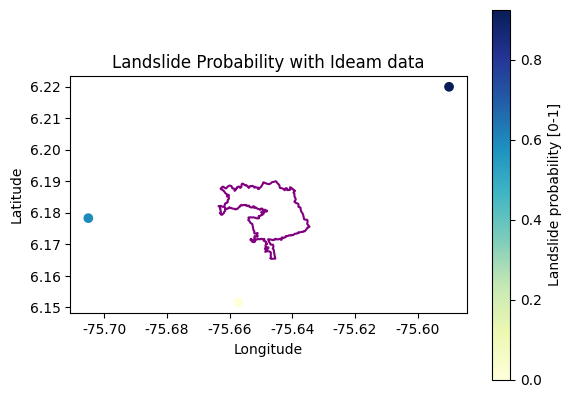

In [ ]:
#Plot the data

fig,ax=plt.subplots(1,1)

#Select landslide probability >0
world_l3=df_prob_lluvia_l3[(df_prob_lluvia_l3.prob_ep>=0)]

#Plot the region limit
limite_region_l3.boundary.plot(ax=ax,color='purple', edgecolor='red')

#Plot landslide probability
ax.set_title("Landslide Probability with Ideam data", fontsize=12)
world_l3.plot(column='prob_ep', cmap="YlGnBu",
             ax=ax,
             legend=True,
             legend_kwds={'label': "Landslide probability [0-1]",
                            'orientation': "vertical"})
ax.xaxis.set_major_formatter(FuncFormatter(format_two_decimals))
ax.yaxis.set_major_formatter(FuncFormatter(format_two_decimals))

#Customize axis labels
ax.set_xlabel("Longitude", fontsize=10)
ax.set_ylabel("Latitude", fontsize=10)


#Show plot
plt.show()

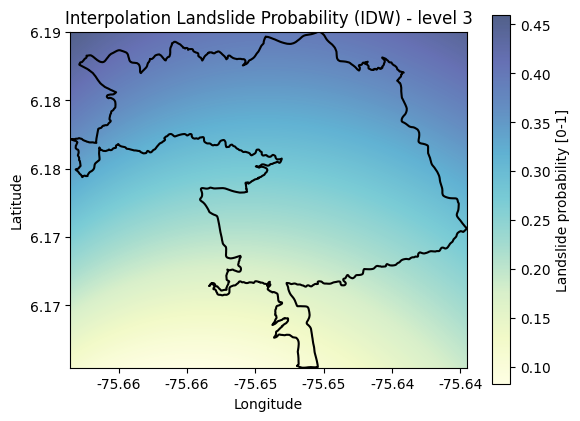

In [ ]:
#Interpolate data with IDW method

variables= ['CODIGO', 'nombre', 'CATEGORIA', 'TECNOLOGIA', 'ESTADO',
             'altitud', 'latitud', 'longitud', 'DEPARTAMEN', 'MUNICIPIO',
             'geometry', 'prob_ep']

gdf_l3 = gpd.GeoDataFrame(df_prob_lluvia_l3[variables], geometry='geometry')

points = np.array([[geom.x, geom.y] for geom in gdf_l3.geometry])
values = gdf_l3['prob_ep'].values

#Get region limits
min_x, min_y, max_x, max_y = limite_region_l3.total_bounds

#Create interpolation grid
grid_x, grid_y = np.mgrid[min_x:max_x:500j, min_y:max_y:500j]

#Use previous function created
grid_z = idw_interpolation(points[:, 0], points[:, 1], values, grid_x, grid_y, power=2)

#Result visualization

fig, ax = plt.subplots()
ax.set_title("Interpolation Landslide Probability (IDW) - level 3", fontsize=12 )
limite_region_l3.boundary.plot(ax=ax, color='black', edgecolor='black')

# Show 2 decimals
ax.xaxis.set_major_formatter(FuncFormatter(format_two_decimals))
ax.yaxis.set_major_formatter(FuncFormatter(format_two_decimals))

#Customize axis labels

ax.set_xlabel("Longitude", fontsize=10)
ax.set_ylabel("Latitude", fontsize=10)

#Show interpolation in the whole square
cax = ax.imshow(grid_z.T, extent=(min_x, max_x, min_y, max_y),
                origin='lower', cmap='YlGnBu', alpha=0.7)
plt.colorbar(cax, label='Landslide probability [0-1]')

#Points of original gauges
#gdf_l3.plot(ax=ax, markersize=20, color='yellow', edgecolor='black', marker='*')
plt.show()


In [ ]:
#Chose scenario to define empirical rainfall thresholds.

 #Scenario 1: Fine soils (silt and clay) in dry periods
 #Scenario 2: Fine soils with presence of sand and coarse materials in rainy periods
 #Scenario 3: Fine soils in rainy periods

#Define scenarios with a dictionary:
scenarios = {
    "1": "Fine soils (silt and clay) in dry periods",
    "2": "Fine soils with presence of sand and coarse materials in rainy periods",
    "3": "Fine soils in rainy periods"
}

#Show options to user
print("Please choose one of the following scenarios:")
for key, value in scenarios.items():
    print(f"{key}. {value}")

while True:
    seleccion = input("Enter the scenario number (1, 2, or 3): ").strip()
    if seleccion in scenarios:
        print(f"\n You have selected: {scenarios[seleccion]}")
        break  # Salir del bucle si la selección es válida
    else:
        print("\n Invalid input. Please enter 1, 2, or 3.")

# Save number of selected scenario

selected=int(seleccion)



Please choose one of the following scenarios:
1. Fine soils (silt and clay) in dry periods
2. Fine soils with presence of sand and coarse materials in rainy periods
3. Fine soils in rainy periods
Enter the scenario number (1, 2, or 3): 3

 You have selected: Fine soils in rainy periods


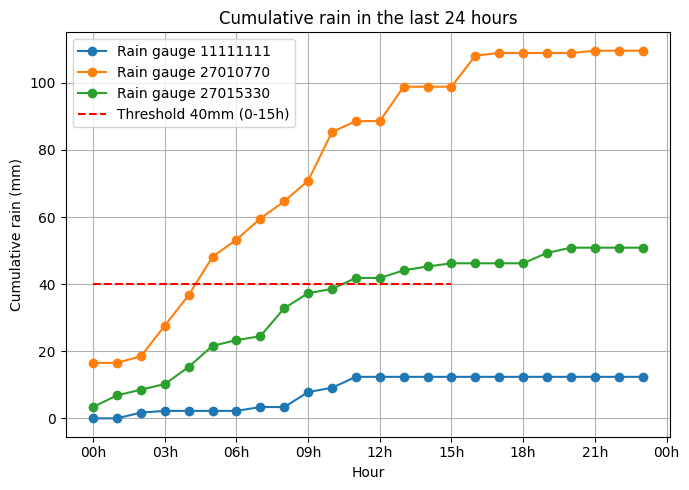

In [ ]:
# ------ Plot cumulated rain in the last 24h ------
def plot_24h(df_hourly, scenario):
    #Ensure datetime format
    df_hourly['fecha_hora'] = pd.to_datetime(df_hourly['fecha_hora'], errors='coerce')

    #Delete invalid rows
    df_hourly = df_hourly.dropna(subset=['fecha_hora'])

    #Filter last 24 hours
    ultima_fecha_hora = df_hourly['fecha_hora'].max()
    inicio_24h = ultima_fecha_hora - pd.Timedelta(hours=23)

    # Create dataframe last 24 hours
    filtro_24h = df_hourly [(df_hourly['fecha_hora'] >= inicio_24h) & (df_hourly['fecha_hora'] <= ultima_fecha_hora)]
    filtro_24h = filtro_24h.sort_values(by='fecha_hora')

    plt.figure(figsize=(7, 5))

    # Plot the data by rain gauge
    estaciones = filtro_24h['Codigo'].unique()
    for estacion in estaciones:
        datos_estacion = filtro_24h[filtro_24h['Codigo'] == estacion].copy()
        datos_estacion['Accumulated Rain'] = datos_estacion['rain_hourly'].cumsum()
        plt.plot(datos_estacion['fecha_hora'], datos_estacion['Accumulated Rain'], marker='o', label=f'Rain gauge {estacion}')

    # Add rainfall threshold according to the scenario
    if scenario == 2:
        # Scenario #2
        horas = filtro_24h['fecha_hora'].unique()[:16]  # Select first 15 hours (0-15h)
        plt.plot(horas, [30] * len(horas), color='red', linestyle='--', label='Threshold 30mm (0-15h)')
        plt.plot(horas, [60] * len(horas), color='red', linestyle='--', label='Threshold 60mm (0-15h)')
    elif scenario == 3:
        # #Scenario #3
        horas = filtro_24h['fecha_hora'].unique()[:16]  # Select first 15 hours (0-15h)
        plt.plot(horas, [40] * len(horas), color='red', linestyle='--', label='Threshold 40mm (0-15h)')

    # Plot settings
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Hh'))  # Formato del eje X
    plt.xticks(rotation=0)
    plt.title('Cumulative rain in the last 24 hours')
    plt.xlabel('Hour')
    plt.ylabel('Cumulative rain (mm)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_24h(hourly_data, selected)



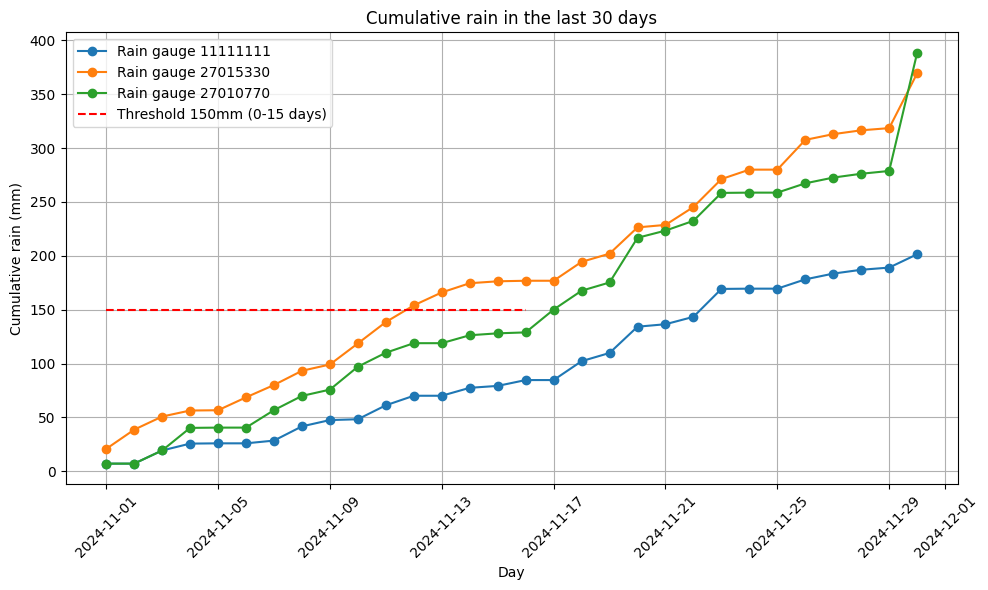

In [ ]:
# ------ Plot cumulative rain in the last 30 days ------
def plot_30days(df_daily, scenario):

    #Ensure datetime format
    df_daily['fecha'] = pd.to_datetime(df_daily['fecha'], errors='coerce')

    #Delete invalid rows
    df_daily = df_daily.dropna(subset=['fecha'])

    #Filter last 30 days
    ultima_fecha = df_daily['fecha'].max()
    inicio_30d = ultima_fecha - pd.Timedelta(days=29)

    #Create dataframe 30 days
    filtro_30d = daily_data[(daily_data['fecha'] >= inicio_30d) & (daily_data['fecha'] <= ultima_fecha)]
    filtro_30d = filtro_30d.sort_values(by='fecha')

    plt.figure(figsize=(10, 6))

    # Plot cumulative rain by rain gauge
    estaciones = filtro_30d['Codigo'].unique()
    for estacion in estaciones:
        datos_estacion = filtro_30d[filtro_30d['Codigo'] == estacion].copy()
        datos_estacion['Accumulated Rain'] = datos_estacion['daily_rain'].cumsum()
        plt.plot(datos_estacion['fecha'], datos_estacion['Accumulated Rain'], marker='o', label=f'Rain gauge {estacion}')

    # Add rainfall threshold depending on the scenario
    if scenario == 1:
        # Scenario 1
        plt.axhline(y=200, color='red', linestyle='--', label='Threshold 200mm')
    elif scenario == 2:
        # Scenario 2
        dias = filtro_30d['fecha'].unique()[:16]  # Seleccionar los primeros 16 días (0-15 días)
        plt.plot(dias, [100] * len(dias), color='red', linestyle='--', label='Threshold 100mm (0-15 days)')
    elif scenario == 3:
        # Scenario 3
        dias = filtro_30d['fecha'].unique()[:16]  # Seleccionar los primeros 16 días (0-15 días)
        plt.plot(dias, [150] * len(dias), color='red', linestyle='--', label='Threshold 150mm (0-15 days)')

    # Plot settings
    plt.title('Cumulative rain in the last 30 days')
    plt.xlabel('Day')
    plt.xticks(rotation=45)
    plt.ylabel('Cumulative rain (mm)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_30days(daily_data, selected)